<a href="https://colab.research.google.com/github/jennylin2003/jennylin2003/blob/main/JPMC4Zillow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import used modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
#Import from google drive in order to get the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Check the common values of the data
df_prop = pd.read_csv('/content/drive/MyDrive/properties_2017.csv.zip')
df_train = pd.read_csv('/content/drive/MyDrive/train_2017.csv')
df = pd.merge(df_prop, df_train, how = 'left', on = 'parcelid')
df.describe()

In [ ]:
#See size
df.shape

(2985416, 60)

In [ ]:
#See types
df.dtypes

parcelid                          int64
airconditioningtypeid           float64
architecturalstyletypeid        float64
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingclasstypeid             float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
decktypeid                      float64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
finishedsquarefeet6             float64
fips                            float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
hashottuborspa                   object
heatingorsystemtypeid           float64
latitude                        float64


In [ ]:
#Checking out parcelid
print("The number of unique parcelids:",df['parcelid'].nunique())
print("The number of rows:", df['parcelid'].shape[0])

The number of unique parcelids: 2985217
The number of rows: 2985416


<Figure size 1200x1200 with 0 Axes>

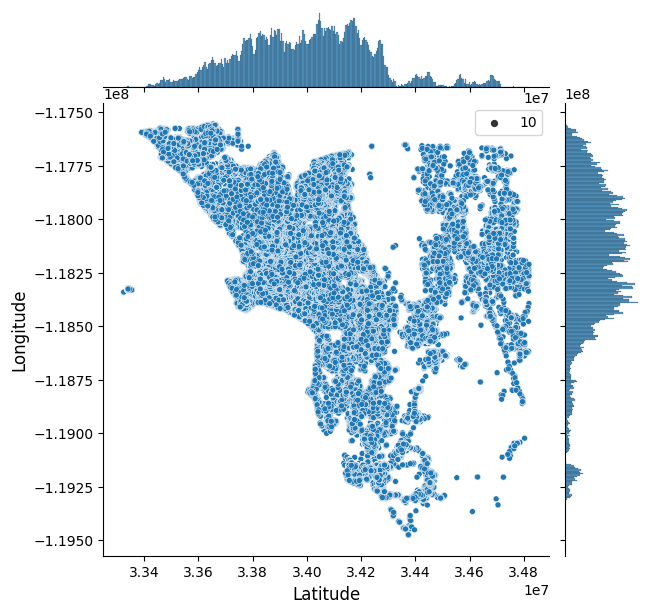

In [ ]:
#EDA

plt.figure(figsize=(12,12))
sns.jointplot(x=df.latitude.values, y=df.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

In [ ]:
#Check out head of the data
df.head

<bound method NDFrame.head of          parcelid  airconditioningtypeid  architecturalstyletypeid  \
0        10754147                    NaN                       NaN   
1        10759547                    NaN                       NaN   
2        10843547                    NaN                       NaN   
3        10859147                    NaN                       NaN   
4        10879947                    NaN                       NaN   
...           ...                    ...                       ...   
2985411  12170430                    NaN                       NaN   
2985412  11422430                    NaN                       NaN   
2985413  17203030                    NaN                       NaN   
2985414  14242830                    NaN                       NaN   
2985415  12766630                    NaN                       NaN   

         basementsqft  bathroomcnt  bedroomcnt  buildingclasstypeid  \
0                 NaN          0.0         0.0            

#Lots of null values...

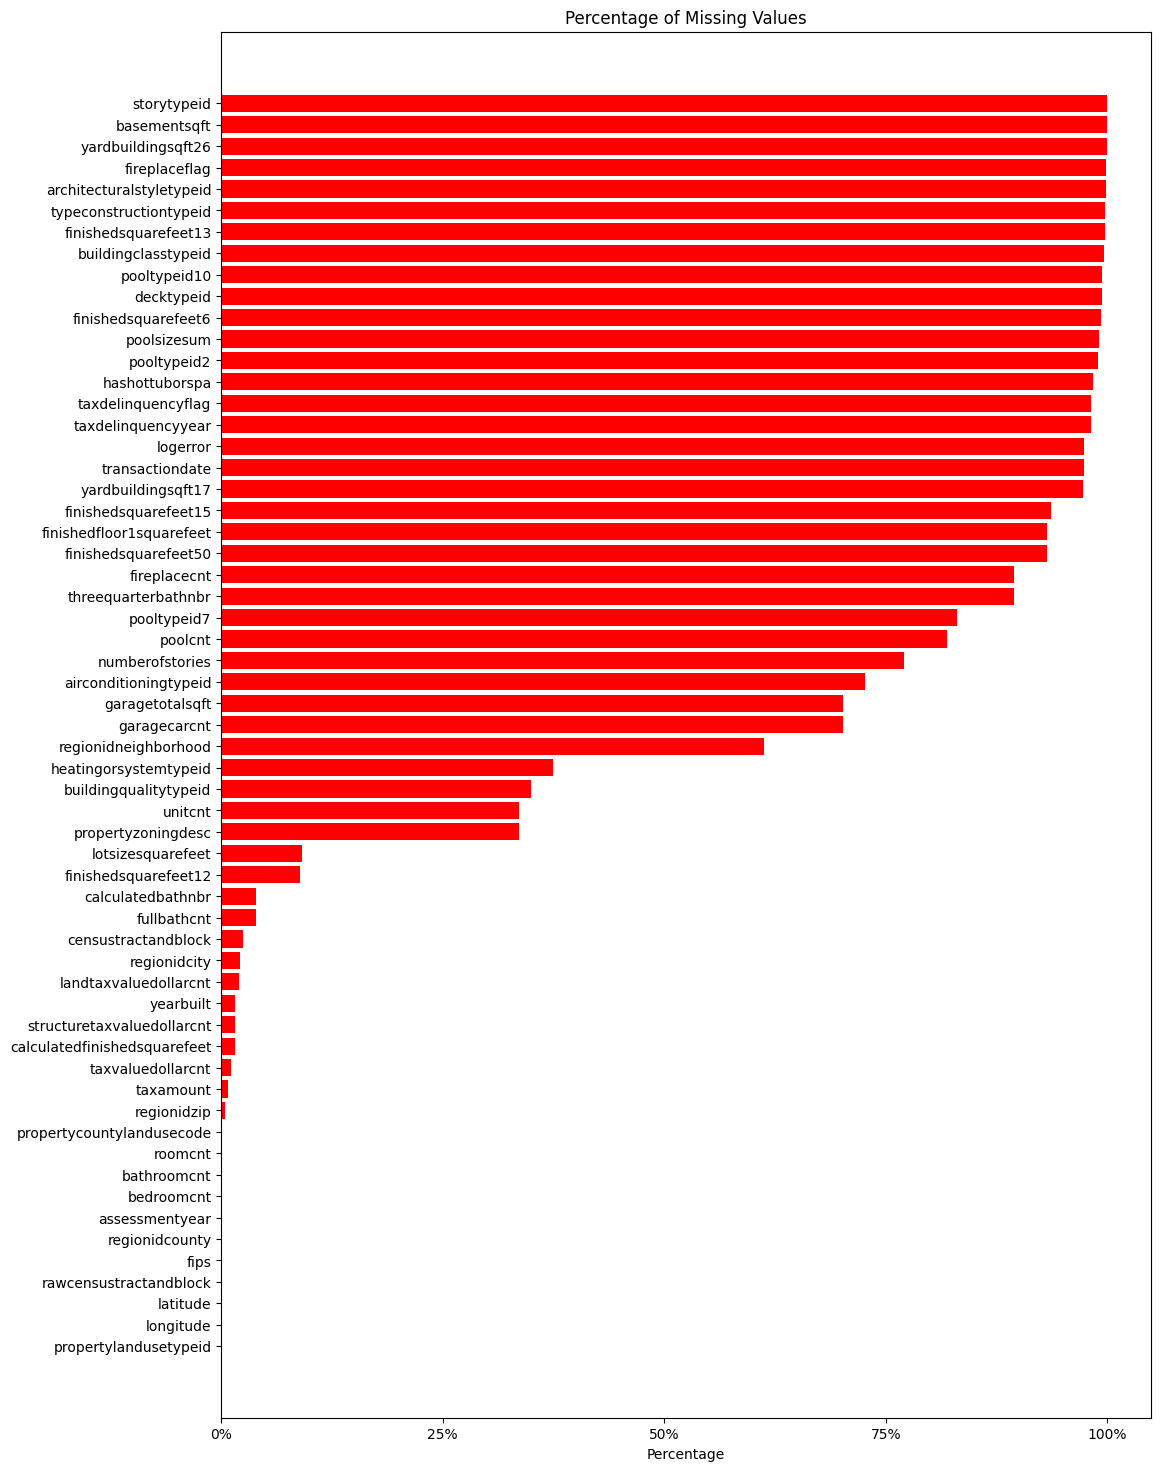

In [ ]:
# Visualizing missing values
null_df = df.isnull().sum(axis=0).reset_index()
null_df.columns = ['column_name', 'missing_count']
null_df = null_df.loc[null_df['missing_count'] > 0]
null_df = null_df.sort_values(by='missing_count')

total_size = len(df)
null_df['percent_missing'] = (null_df['missing_count'] / total_size) * 100

ind = np.arange(null_df.shape[0])
width = 1
fig, ax = plt.subplots(figsize=(12, 18))
rects = ax.barh(ind, null_df['percent_missing'], color='red')
ax.set_yticks(ind)
ax.set_yticklabels(null_df['column_name'], rotation='horizontal')
ax.set_xticks([0, 25, 50, 75, 100])
ax.set_xticklabels(["0%", "25%", "50%", "75%", "100%"], rotation='horizontal')
ax.set_title("Percentage of Missing Values")
plt.xlabel("Percentage")
plt.show()


In [ ]:
null_counts = df.isnull().sum()

# filter columns with null values
columns_with_nulls = null_counts[null_counts > 0]

# print the columns with null values and their respective null counts
for column, null_count in columns_with_nulls.items():
    print(f"Column '{column}':{null_count} null values.")

Column 'airconditioningtypeid':2170000 null values.
Column 'architecturalstyletypeid':2979354 null values.
Column 'basementsqft':2983789 null values.
Column 'bathroomcnt':2958 null values.
Column 'bedroomcnt':2946 null values.
Column 'buildingclasstypeid':2972685 null values.
Column 'buildingqualitytypeid':1043884 null values.
Column 'calculatedbathnbr':117164 null values.
Column 'decktypeid':2968037 null values.
Column 'finishedfloor1squarefeet':2781644 null values.
Column 'calculatedfinishedsquarefeet':45103 null values.
Column 'finishedsquarefeet12':264456 null values.
Column 'finishedsquarefeet13':2977744 null values.
Column 'finishedsquarefeet15':2795213 null values.
Column 'finishedsquarefeet50':2781644 null values.
Column 'finishedsquarefeet6':2963934 null values.
Column 'fips':2933 null values.
Column 'fireplacecnt':2672279 null values.
Column 'fullbathcnt':117164 null values.
Column 'garagecarcnt':2094362 null values.
Column 'garagetotalsqft':2094362 null values.
Column 'hasho

In [ ]:
# Drop columns that have null values for over 70% of the data values
columns_to_include = ['parcelid', 'logerror', 'transactiondate']
df_train = df[columns_to_include]
df.drop(columns = df.columns[df.isnull().sum() > df.shape[0]*0.7], inplace = True)
df = pd.merge(df, df_train, how = 'left', on = 'parcelid')
#The remaining columns:
df.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedbathnbr', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'fips', 'fullbathcnt', 'heatingorsystemtypeid',
       'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'unitcnt', 'yearbuilt', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'censustractandblock', 'logerror', 'transactiondate'],
      dtype='object')

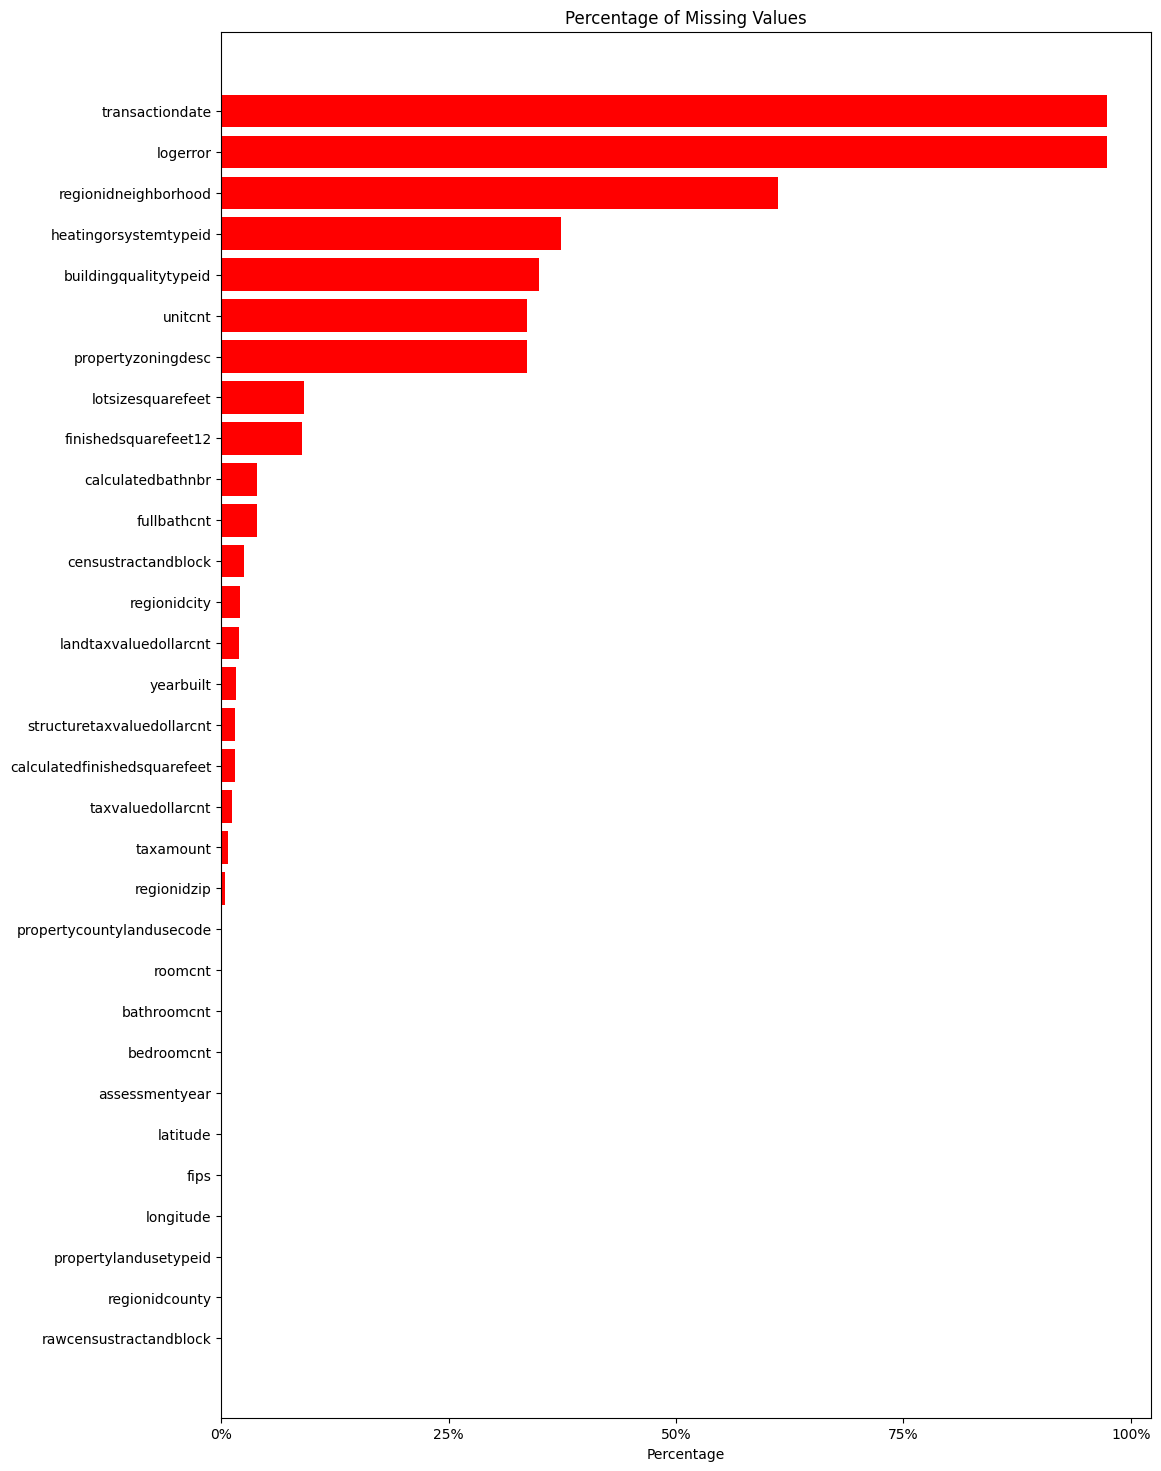

In [ ]:
# Nice, now the missing values arent as bad.
null_df = df.isnull().sum(axis=0).reset_index()
null_df.columns = ['column_name', 'missing_count']
null_df = null_df.loc[null_df['missing_count'] > 0]
null_df = null_df.sort_values(by='missing_count')

total_size = len(df)
null_df['percent_missing'] = (null_df['missing_count'] / total_size) * 100

ind = np.arange(null_df.shape[0])
width = 1
fig, ax = plt.subplots(figsize=(12, 18))
rects = ax.barh(ind, null_df['percent_missing'], color='red')
ax.set_yticks(ind)
ax.set_yticklabels(null_df['column_name'], rotation='horizontal')
ax.set_xticks([0, 25, 50, 75, 100])
ax.set_xticklabels(["0%", "25%", "50%", "75%", "100%"], rotation='horizontal')
ax.set_title("Percentage of Missing Values")
plt.xlabel("Percentage")
plt.show()


#Now to deal with the reset of the missing values using:


*   Mode
*   Median
*   Bfill
*   Ffill


In [ ]:
# fill buildingqualitytypeid with mode
df['buildingqualitytypeid'].fillna(df.buildingqualitytypeid.mode()[0], inplace = True)

In [ ]:
# fill calculatedbathnbr with median
df['calculatedbathnbr'].fillna(df.bedroomcnt.median(), inplace = True)

In [ ]:
# fill bathroomcnt with median
df['bathroomcnt'].fillna(df.bathroomcnt.median(), inplace = True)

In [ ]:
# fill bedroomcnt with median
df['bedroomcnt'].fillna(df.bedroomcnt.median(), inplace = True)

In [ ]:
# fill buildingqualitytypeid with median
df['calculatedbathnbr'].fillna(df.calculatedbathnbr.median(), inplace = True)

We sort by parcel ID so that when we implement the bfill and ffill, the remaining columns would have values close to their neighbors

In [ ]:
#Sort by the parcelid
df.sort_values(by=['parcelid'], inplace = True)

#Bfill & Ffill
df.bfill(inplace = True)
df.ffill(inplace = True)

df.isnull().sum()

parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
buildingqualitytypeid           0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
finishedsquarefeet12            0
fips                            0
fullbathcnt                     0
heatingorsystemtypeid           0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
propertylandusetypeid           0
propertyzoningdesc              0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidneighborhood            0
regionidzip                     0
roomcnt                         0
unitcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
censustractand

In [ ]:
#Checking whether the columns are numerical
ensure_numerical = df.isnull().sum() != 0 & (df.dtypes == 'int64') | (df.dtypes == 'float64')
ensure_numerical

parcelid                        False
bathroomcnt                      True
bedroomcnt                       True
buildingqualitytypeid            True
calculatedbathnbr                True
calculatedfinishedsquarefeet     True
finishedsquarefeet12             True
fips                             True
fullbathcnt                      True
heatingorsystemtypeid            True
latitude                         True
longitude                        True
lotsizesquarefeet                True
propertycountylandusecode       False
propertylandusetypeid            True
propertyzoningdesc              False
rawcensustractandblock           True
regionidcity                     True
regionidcounty                   True
regionidneighborhood             True
regionidzip                      True
roomcnt                          True
unitcnt                          True
yearbuilt                        True
structuretaxvaluedollarcnt       True
taxvaluedollarcnt                True
assessmentye

### Removing Duplicates


In [ ]:
#There are no rows with the same exact column values; duplicates should not be problematic in this case.
duplicate_rows = df[df.duplicated()]
print(duplicate_rows)

          parcelid  bathroomcnt  bedroomcnt  buildingqualitytypeid  \
16181     10722858          2.0         4.0                    6.0   
16182     10722858          2.0         4.0                    6.0   
1836436   10732347          2.0         4.0                    8.0   
1836437   10732347          2.0         4.0                    8.0   
2119625   10739478          3.0         4.0                    8.0   
...            ...          ...         ...                    ...   
2939303   17282392          2.0         3.0                    6.0   
2506897   17295416          2.0         2.0                    6.0   
2506896   17295416          2.0         2.0                    6.0   
2415629  162960529          4.0         4.0                    6.0   
2415628  162960529          4.0         4.0                    6.0   

         calculatedbathnbr  calculatedfinishedsquarefeet  \
16181                  2.0                        1570.0   
16182                  2.0             

## Reformatting Categorical Data

In [ ]:
#Method Used: One Hot Encoding, pd.get_dummies()

#Categorical Data that need to be reformatted:
#- propertyzoningdesc          (dtype: object)
#- propertycountrylandusecode  (dtype: object)

print(df.propertyzoningdesc.unique())
print(df.propertycountylandusecode.unique())
print(df.propertyzoningdesc.value_counts())
print(df.propertycountylandusecode.value_counts())

['LARE9' 'LARE11' 'LARS' ... 'LAR-1' 'PDCP' 'LBPD13']
['0101' '0100' '0104' '0103' '0108' '010D' '010G' '0109' '1200' '010M'
 '010V' '010X' '0200' '1210' '100V' '01DC' '010C' '010E' '0131' '0201'
 '1722' '0400' '12T0' '8800' '0102' '012C' '0300' '0133' '020V' '0700'
 '0111' '0105' '070D' '300V' '0600' '020C' '1202' '0130' '0208' '1211'
 '1203' '1720' '1201' '0301' '0401' '010F' '012E' '010H' '070V' '1216'
 '0230' '1214' '030V' '020M' '01DE' '0203' '030D' '040V' '0303' '1217'
 '1181' '0121' '0402' '01HC' '1213' '0113' '040B' '0132' '1212' '010Y'
 '0110' '0450' '5900' '0209' '0420' '030L' '10G' '101' '0710' '12T2'
 '0202' '0701' '4400' '12T4' '070M' '0140' '070X' '0120' '04TO' '201'
 '070P' '121L' '010L' '4101' '0730' '0204' '07M' '070L' '880V' '0309'
 '01DD' '0410' '12TO' '1724' '030C' '120C' '0106' '121C' '0118' '020G'
 '0114' '104' '0304' '2003' '120T' '10C' '1002' '10E' '1215' '1723' '0403'
 '0409' '030G' '1204' '120G' '1206' '040A' '0123' '01HE' '030E' '0115'
 '011C' '020A' '0711' '

In [ ]:
""" Will not be using
one_hot_encoded_data = pd.get_dummies(df, columns = ['propertyzoningdesc', 'propertycountylandusecode'])
one_hot_encoded_data
new_df = pd.concat([df, one_hot_encoded_data], axis= 1)
new_df
new_df.drop(columns = ['propertyzoningdesc', 'propertycountylandusecode'], inplace = True)
new_df
"""

" Will not be using\none_hot_encoded_data = pd.get_dummies(df, columns = ['propertyzoningdesc', 'propertycountylandusecode'])\none_hot_encoded_data\nnew_df = pd.concat([df, one_hot_encoded_data], axis= 1)\nnew_df\nnew_df.drop(columns = ['propertyzoningdesc', 'propertycountylandusecode'], inplace = True)\nnew_df\n"

## Feature Engineering


In [ ]:
#Living area proportions
df['living_area_prop'] = df['calculatedfinishedsquarefeet'] / df['lotsizesquarefeet']
#Tax value ratio
df['value_ratio'] = df['taxvaluedollarcnt'] / df['taxamount']
#Tax value proportions
df['value_prop'] = df['structuretaxvaluedollarcnt'] / df['landtaxvaluedollarcnt']

#Removing Outliers

In [ ]:
log_errors = df['logerror']
df = df[df.logerror < np.percentile(log_errors, 99.5)]
df = df[df.logerror > np.percentile(log_errors, 0.5)]

<ipython-input-29-b8e6120841a7>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.logerror.values, bins=50, kde=False)


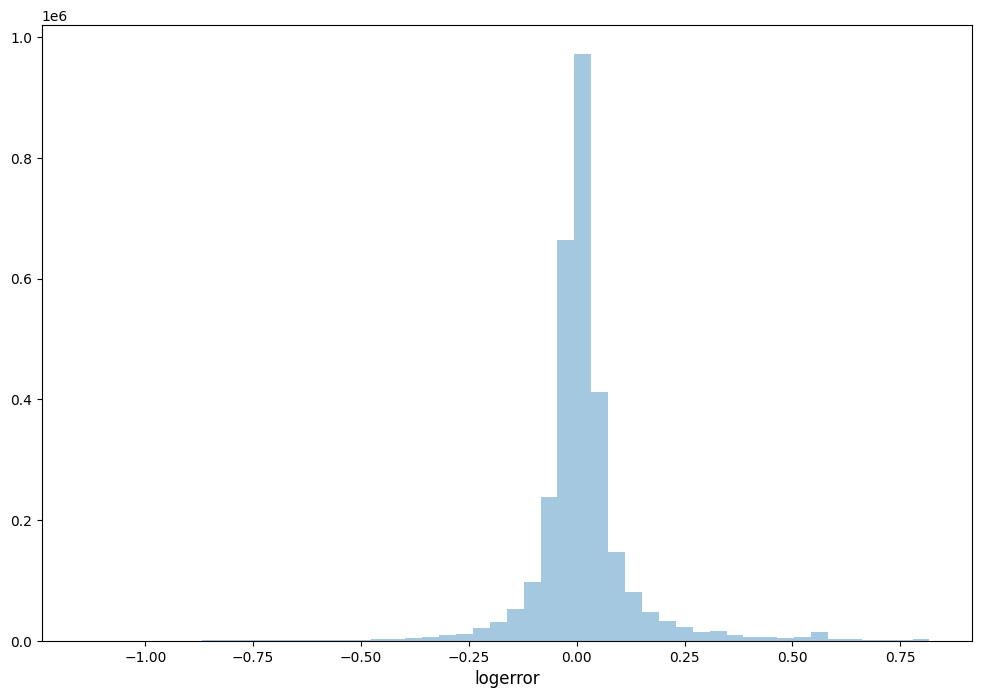

In [ ]:
plt.figure(figsize=(12,8))
sns.distplot(df.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

#Correlation Analysis

<ipython-input-30-fd7b3c436d02>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = pd.DataFrame(df.corr()['logerror'].sort_values(ascending = False)).rename(columns = {'logerror':'correlation'})


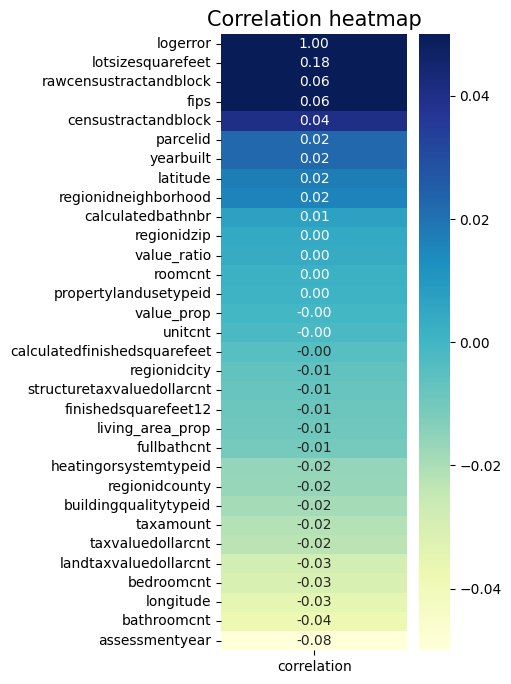

In [ ]:
corr = pd.DataFrame(df.corr()['logerror'].sort_values(ascending = False)).rename(columns = {'logerror':'correlation'})

plt.figure(figsize = (3,8))
sns.heatmap(corr, annot = True, fmt = '.2f', vmin = -0.05, vmax = 0.05, cmap = 'YlGnBu')
plt.title('Correlation heatmap', fontsize = 15)
plt.show()

<ipython-input-31-3498687e6362>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = df.corr()


<Axes: >

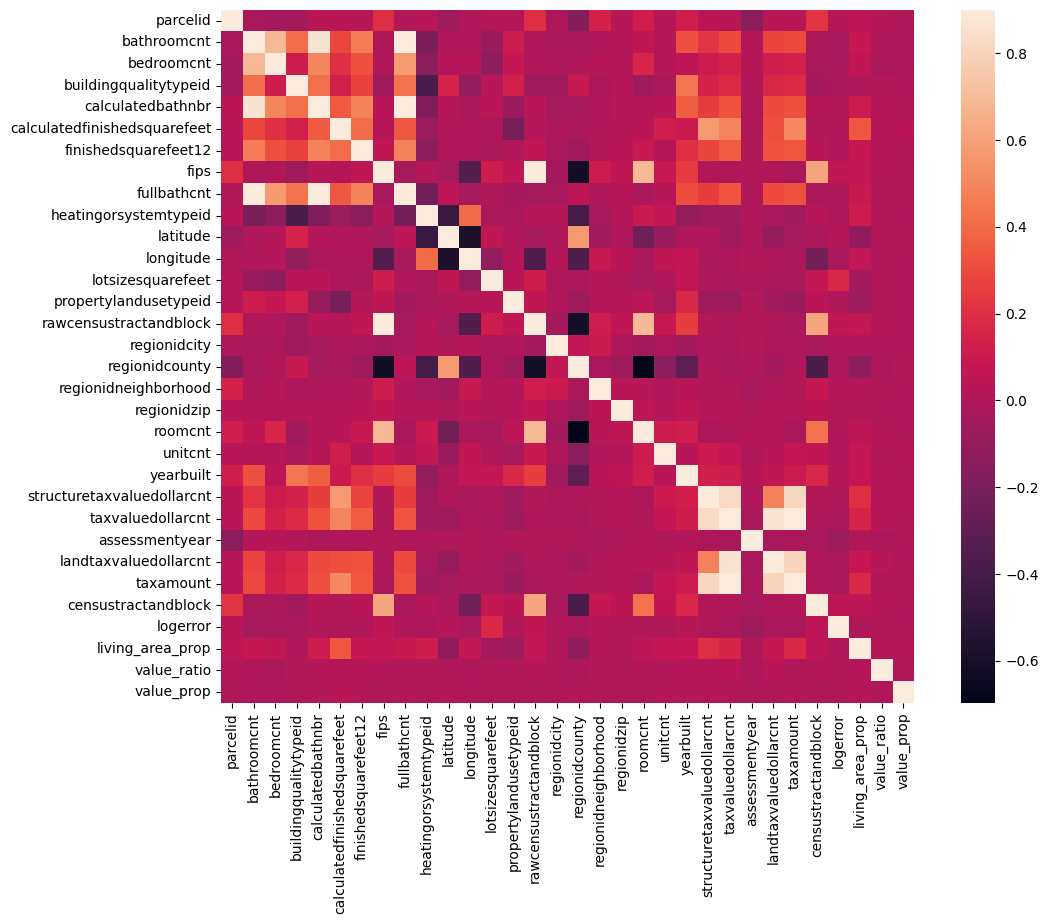

In [ ]:
corrmat = df.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [ ]:
# Now we'll select the most highly correlated columns to use as our features
x_cols = [col for col in df.columns if col not in ['logerror'] if df[col].dtype == 'float64']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(df[col].values, df.logerror.values)[0,1])

corr_df = pd.DataFrame({'col_labels' : labels, 'corr_values' : values})
corr_df = corr_df.sort_values(by='corr_values')

corr_df = corr_df.loc[(corr_df['corr_values'] > 0.02) | (corr_df['corr_values'] < -0.02)]

In [ ]:
corr_df

,col_labels,corr_values
23,assessmentyear,-0.075866
0,bathroomcnt,-0.037743
10,longitude,-0.034560
1,bedroomcnt,-0.030572
24,landtaxvaluedollarcnt,-0.028764
22,taxvaluedollarcnt,-0.022785
25,taxamount,-0.021791
20,yearbuilt,0.022516
26,censustractandblock,0.039921
6,fips,0.055480


In [ ]:
feature_cols = corr_df.col_labels.to_list()

# Deep Learning Model for Regression

In [ ]:
features = torch.tensor(df[feature_cols].values, dtype=torch.float32)
labels = torch.tensor(df['logerror'].values, dtype=torch.float32)
dataset = TensorDataset(features, labels)
data_loader = DataLoader(dataset, batch_size=100, shuffle=True)

class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

input_size = len(feature_cols)
hidden_size = 5
output_size = 1


model = Net(features.shape[1],1)

criterion = nn.MSELoss()
learning_rate = 0.001
l2_lambda = 0.01

optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

num_epochs = 10
for epoch in range(num_epochs):
    for i, (x_train, y_train)  in enumerate(data_loader):
      y_pred = model(x_train)
      loss = criterion(y_pred,y_train)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss:.4f}')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([44])) that is different to the input size (torch.Size([44, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/100], Loss: 0.0106
Epoch [2/100], Loss: 0.0298
Epoch [3/100], Loss: 0.0206
Epoch [4/100], Loss: 0.0090
Epoch [5/100], Loss: 0.0152
Epoch [6/100], Loss: 0.0054
Epoch [7/100], Loss: 0.0107
Epoch [8/100], Loss: 0.0104
Epoch [9/100], Loss: 0.0234
Epoch [10/100], Loss: 0.0124
Epoch [11/100], Loss: 0.0080
Epoch [12/100], Loss: 0.0119
Epoch [13/100], Loss: 0.0266
Epoch [14/100], Loss: 0.0288
Epoch [15/100], Loss: 0.0253
Epoch [16/100], Loss: 0.0224
Epoch [17/100], Loss: 0.0080
Epoch [18/100], Loss: 0.0101
Epoch [19/100], Loss: 0.0094
Epoch [20/100], Loss: 0.0122
Epoch [21/100], Loss: 0.0131
Epoch [22/100], Loss: 0.0077
Epoch [23/100], Loss: 0.0130
Epoch [24/100], Loss: 0.0152
Epoch [25/100], Loss: 0.0049
Epoch [26/100], Loss: 0.0161
Epoch [27/100], Loss: 0.0230
Epoch [28/100], Loss: 0.0019
Epoch [29/100], Loss: 0.0099
Epoch [30/100], Loss: 0.0089
Epoch [31/100], Loss: 0.0108
Epoch [32/100], Loss: 0.0230
Epoch [33/100], Loss: 0.0168
Epoch [34/100], Loss: 0.0029
Epoch [35/100], Loss: 0

Store model into google drive

In [ ]:
model_path = '/content/drive/MyDrive/NNModel.pth'
torch.save(model.state_dict(), model_path)

In [ ]:
 model_state_dict = torch.load(model_path)
# Define the model architecture
input_size = len(feature_cols)
hidden_size = 5
output_size = 1
loaded_model = Net(input_size, output_size)

# Load the saved model parameters
loaded_model.load_state_dict(model_state_dict)

# Put the loaded model in evaluation mode if necessary
loaded_model.eval()



FileNotFoundError: ignored